# Statistical learning (IMC-4302C)

1. [Nearest neighbor](#Nearest-neighbor)
1. [$k$-nearest neighbors](#$k$-nearest-neighbors)
1. [Evaluating models](#Evaluating-models)

In [1]:
from sllab import *


Packages:
    numpy as np
    matplotlib.pyplot as plt

Functions:
    plotXY
    plot_frontiere
    map_regions



## Nearest neighbor
The nearest neighbor classification is one of the simplest supervised learning methods. Let a training set be composed of $N$ observations $X = \{ x^{(1)}, \dots, x^{(N)} \}$ of dimension $d$ and its associated classes $y = \{ C_1, \dots, C_N \}$. **The classification of an unknown observation $x$ is done by finding the class of its closest neighbor** (usually against the euclidian distance) among the obervations $X$.

>Compute the complexity (the number of operations needed) of a classification. What is the cost of the learning phase ?

>Compute the size of the model (the number of parameters to save in memory to make a classification). Compare with logistic regression.

>Using python's $\verb!class!$ structure, implement a classifier that makes a classification by nearest neighbourg.

In [2]:
# This is not the only way of doing it

from operator import itemgetter

class kNn:
    
    def __init__(self, k=1, dist=None, weight=None):
        self.X = None
        self.y = None
        
        self.k = k

        if dist is None:
            dist = (lambda a,b : np.sqrt(((np.array(a) - np.array(b))**2).sum()))
        self.dist = dist
        
        if weight is None:
            weight = (lambda d : 1)
        self.weight = weight

    def fit(self, X, y):
        self.X = X
        self.y = y        
        return self
    
    def __classify__(self, x):

        # Compute all the distances and weigths in an array : distances = (index, distance, weigth)
        distances = list()

        for i, x_i in enumerate(self.X):
            d = self.dist(x, x_i)
            distances.append([i, d, self.weight(d)])

        # Sort the array by the distances (increasing order) and keep the k-first index
        nn = sorted(distances, key=itemgetter(1))
        knn = np.array(nn[:self.k])
        
        # keep indexes
        knn_ind = knn[:, 0].astype(int)

        # vote
        vote = list()
        labels = np.unique(self.y[knn_ind])
        for label in labels:
            vote.append(sum((self.y[knn_ind] == label)*knn[:, 2]))

        # take the most vote-weighted class        
        label_knn = labels[np.argmax(vote)]

        return label_knn

    def predict(self, X):
        return np.array([self.__classify__(x) for x in X])

 >Test your method on synthetic data. 

In [3]:
from sklearn.datasets import make_blobs

data, target = make_blobs(n_samples=1000, n_features=2, cluster_std=2)     
plotXY(data, target)

>Plot the mapping regions of classification. Comment.

In [4]:
from scipy.spatial.distance import cityblock

fig, ax = plt.subplots(1, 2, figsize=(15,5))

for ax_, (d_name, dist) in zip(ax, (('manhattan', cityblock), ('euclidean', None))):
    knn = kNn(dist=dist)
    knn.fit(data, target)

    #plotXY(data, target, ax=ax_)
    map_regions(knn, data, num=50, ax=ax_)
    ax_.set_title('knn with {} distance'.format(d_name))

## $k$-nearest neighbors
The nearest neighbor method is not robust to variation of data. To palliate that, we use $k$-nearest neighbors : instead of looking just at the closest point, we look for the $k$ closest points. The class chosen at the end is the majority class (voting phase) among those $k$ neighbors.

Several algorithms exist to find the $k$ closest points. The simplest version, linear, is :
- **Input** : a point $x$ unknown and a list of points $X = \{ x^{(1)}, \dots, x^{(N)} \}$
- **Initialization** : let $L$ be the list of the $k$ first elements of $X$, sorted by their distance to the point $x$ (obviously in an ascending order).
- **For** each point $x^{(i)} \in X$, **If** it is closer to $x$ than the last element of $L$ **then**:
  - Delete the last element of $L$
  - Insert $x^{(i)}$ into $L$ in a way that it is still sorted.
- **Return** $L$

Some more complex variants are available in [sklearn.neighbors](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors).

>Adapt your classifier to be a $k$-nearest neighbors classifier.

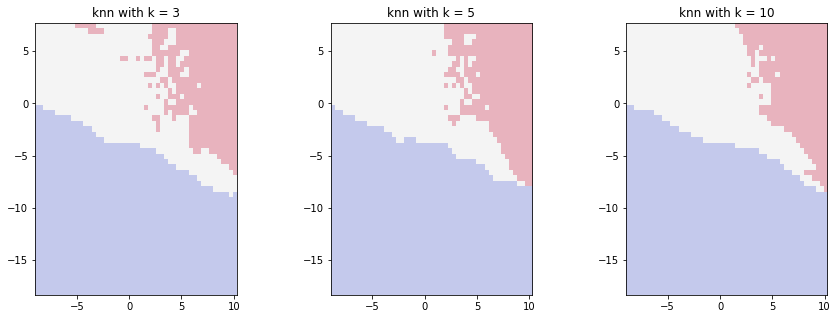

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

for ax_, k in zip(ax, (3, 5, 10)):
    knn = kNn(k)
    knn.fit(data, target)

    #plotXY(data, target, ax=ax_)
    map_regions(knn, data, num=50, ax=ax_)
    ax_.set_title('knn with k = {}'.format(k))

To reduce the influence of the most distant neighbors (and so containing less information), we introduce weights in the vote phase. For each neighborg $x^{(i)}$, the weight associated is $$w_i = \exp \left\{ - \frac{D(x, x^{(i)})}{\sigma^2} \right\}$$ where $\sigma$ is an hyperparameter to determine and $D$ the distance chosen for classification.

>Adapt your previous classifier to use weigth during the vote.

In [6]:
# Done

>Plot the mapping regions of your classification with the same data. Comment.

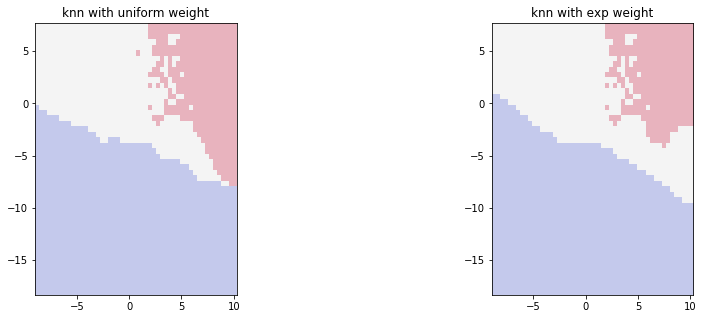

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

for ax_, (w_name, weight) in zip(ax, (('uniform', None), ('exp', lambda d : np.exp(-d)))):
    knn = kNn(5, weight=weight)
    knn.fit(data, target)
    #plotXY(data, target, ax=ax_)
    map_regions(knn, data, num=50, ax=ax_)
    ax_.set_title('knn with {} weight'.format(w_name))

## Evaluating models

>Compute the true positive and false positive rates for different values of $k$.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # Check this function's documentation

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=0)

ks = (1, 3, 5, 10, 20)
n = len(ks)
classes, n_by_classes = np.unique(y_test, return_counts=True)

tp = dict([(c, [0]*n) for c in classes])
fp = dict([(c, [0]*n) for c in classes])

for i, k in enumerate(ks):
    knn = kNn(k).fit(X_train, y_train)
    y_hat = knn.predict(X_test)
    cm = confusion_matrix(y_test, y_hat)
    for c, row in enumerate(cm):
        tp[c][i] = row[c]/n_by_classes[c]
        fp[c][i] = (sum(row) - row[c])/n_by_classes[c]
        

>Plot the true positive rates against the false negative rates.

In [12]:
fig, ax = plt.subplots(1, *classes.shape, figsize=(15, 5))

for ax_, c in zip(ax, classes):
    ax_.plot(ks, tp[c], label='tp')
    ax_.plot(ks, fp[c], label='fp')
    ax_.legend()
    ax_.set_title('class %i'%c)

>Compare the computation times of the learning and predicting phase of logistic regression and a $k$-nn, for several sizes of data sets. Plot those in the same frame. Comment.

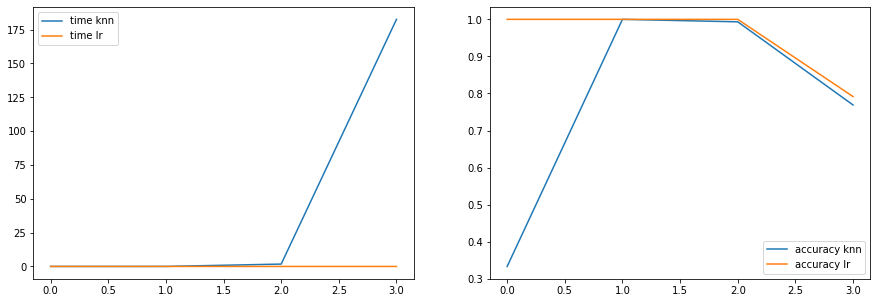

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from time import time

t = list()
accuracy = list()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for n in (10, 100, 1000, 10000):
    data, target = make_blobs(n_samples=n, n_features=2, cluster_std=2)
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

    for clf in kNn(5), LogisticRegression():
        clf.fit(X_train, y_train)
        start = time()
        y_hat = clf.predict(X_test)
        t.append(time() - start)
        accuracy.append(accuracy_score(y_test, y_hat))
        
ax[0].plot(t[::2], label='time knn')
ax[0].plot(t[1::2], label='time lr')
ax[0].legend()

ax[1].plot(accuracy[::2], label='accuracy knn')
ax[1].plot(accuracy[1::2], label='accuracy lr')
ax[1].legend()